## 1.1 Number of orders

In [4]:
import sqlite3
import pandas as pd
db_path = '/content/drive/MyDrive/Olist E-Commerce/olist.sqlite'
db_connection = sqlite3.connect(db_path)

First let's count the total number of daily orders in the dataset and group the by date on the order timestamp and view the first 5 resulting rows:

In [5]:
orders_per_day = """
SELECT
    DATE(order_purchase_timestamp) AS day,
    COUNT(*) AS order_count
FROM orders
GROUP BY day
"""

df = pd.read_sql_query(orders_per_day, db_connection)
df.head(5)

,day,order_count
0,2016-09-04,1
1,2016-09-05,1
2,2016-09-13,1
3,2016-09-15,1
4,2016-10-02,1


In the previous output, we can see that the first days contain very few orders. Let's use matplotlib to visualize the frequency of orders per day:

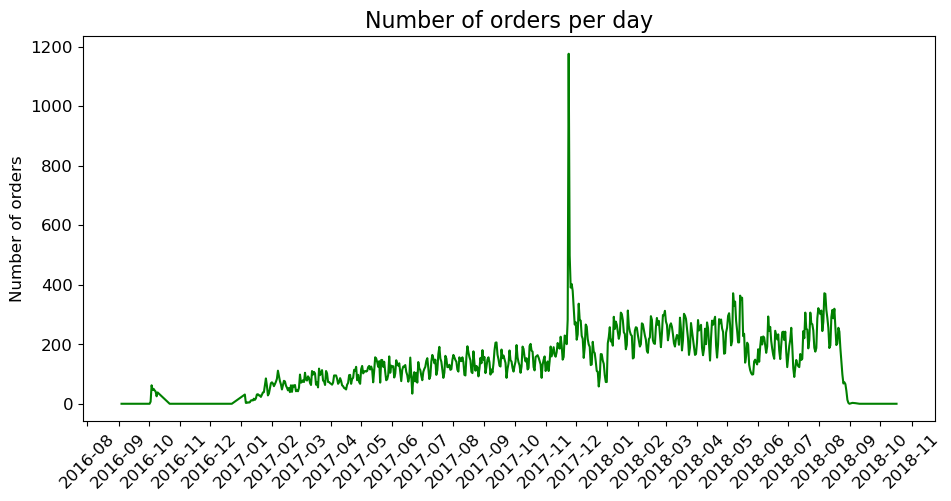

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Increase the default font size globally
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16

# Line plot
plt.figure(figsize=(11, 5))
plt.plot(pd.to_datetime(df['day']), df['order_count'], color='green')
plt.ylabel('Number of orders')
plt.title('Number of orders per day')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.show()

There’s a noticeable spike in orders around Christmas, particularly on December 24th. Additionally, the number of orders appears to be steadily increasing over time, reflecting Olist’s business growth. It’s also worth noting that there’s very limited data at the beginning and end of the dataset’s timespan, so we’ll exclude these periods in some of our upcoming analyses.

How are orders distributed throughout the week? Are weekends busier? And what about the time of day—do customers tend to place more orders in the evening? To explore these questions, we can use a heatmap to visualize the distribution across a grid. For this, we’ll create a matrix where rows represent days of the week, and columns correspond to hours of the day. To generate this heatmap, we’ll start by extracting the day of the week and the hour of the day from each order timestamp using the STRFTIME function.

In [6]:
order_day_hour = """
SELECT
    -- Day of the week abreviated
    CASE STRFTIME('%w', order_purchase_timestamp)
        WHEN '1' THEN 'Mon'
        WHEN '2' THEN 'Tue'
        WHEN '3' THEN 'Wed'
        WHEN '4' THEN 'Thu'
        WHEN '5' THEN 'Fri'
        WHEN '6' THEN 'Sat'
        WHEN '0' THEN 'Sun'
        END AS day_of_week_name,
    -- Day of the week as integer (Sunday=7)
    CAST(STRFTIME('%w', order_purchase_timestamp) AS INTEGER) AS day_of_week_int,
    -- Hour of the day (0-24)
    CAST(STRFTIME("%H", order_purchase_timestamp) AS INTEGER) AS hour
FROM orders
"""

pd.read_sql_query(order_day_hour, db_connection)

,day_of_week_name,day_of_week_int,hour
0,Mon,1,10
1,Tue,2,20
2,Wed,3,8
3,Sat,6,19
4,Tue,2,21
...,...,...,...
99436,Thu,4,9
99437,Tue,2,12
99438,Sun,0,14
99439,Mon,1,21


To efficiently generate a column of the count of orders for each hour of the day in an SQL query, we can use a Python list comprehension. This approach allows us to avoid writing 24 repetitive statements. We'll also use the previous query as a CTE.

In [11]:
count_orders_per_hour = ',\n    '.join([
    f'COUNT(CASE WHEN hour = {i} THEN 1 END) AS "{i}"' \
    for i in range(24)
])

orders_per_day_of_the_week_and_hour = f"""
WITH OrderDayHour AS (
    {order_day_hour}
)
SELECT
    day_of_week_name,
    {count_orders_per_hour}
FROM OrderDayHour
GROUP BY day_of_week_int
ORDER BY
CASE day_of_week_name
    WHEN 'Mon' THEN 1
    WHEN 'Tue' THEN 2
    WHEN 'Wed' THEN 3
    WHEN 'Thu' THEN 4
    WHEN 'Fri' THEN 5
    WHEN 'Sat' THEN 6
    WHEN 'Sun' THEN 7
  END
"""

After executing the query, we just need to set the day_of_the_week_name column as the dataframe index to get the matrix we need to build the heatmap:

In [12]:
df = pd.read_sql_query(orders_per_day_of_the_week_and_hour, db_connection)
df = df.set_index('day_of_week_name')
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_week_name,,,,,,,,,,,,,,,,,,,,,
Mon,328,134,66,36,21,22,69,160,479,783,...,1096,1079,1094,992,928,945,1027,1118,991,717
Tue,306,158,80,28,29,24,71,223,522,864,...,1124,1047,1081,967,877,924,988,1027,965,692
Wed,397,179,81,33,33,27,93,211,517,829,...,1050,983,1040,967,852,848,904,963,878,615
Thu,355,167,75,39,31,28,85,220,502,758,...,977,928,1077,909,784,826,839,840,857,551
Fri,426,216,72,49,40,36,97,206,493,768,...,961,979,974,817,723,784,738,726,702,512
Sat,315,175,67,43,25,24,53,106,249,434,...,677,722,697,701,710,756,730,654,550,429
Sun,267,141,69,44,27,27,34,105,205,349,...,684,716,712,797,895,899,967,889,873,607


### Visualization

With the data matrix ready, we can use seaborn to create the heatmap:

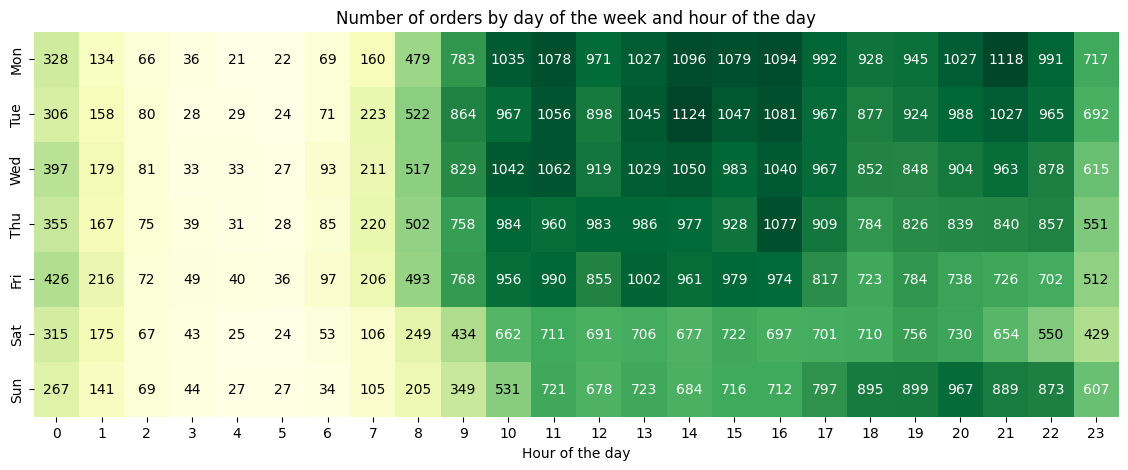

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(df, cmap='YlGn', cbar=False)
mean_orders = df.mean().mean()
for i in range(len(df)):
    for j in range(len(df.columns)):
        text_color = 'white' if df.iloc[i, j] > mean_orders else 'black'
        ax.text(j+0.5, i+0.5, int(df.iloc[i, j]),
            color=text_color, fontsize=10, ha="center", va="center")
plt.title("Number of orders by day of the week and hour of the day")
plt.xlabel("Hour of the day")
plt.ylabel("")
plt.show()

Most orders are placed on weekdays between 10 AM and 4 PM, with a slight dip around noon, likely due to lunchtime. Customers also tend to place orders in the evenings, especially around 9 PM, from Sunday to Thursday. Saturday sees the fewest orders overall, though it remains relatively active. The quietest time of day is between 3 and 5 AM, although a few orders still occur during these early hours.

## 1.2 Geographic Distribution

Having analyzed the temporal distribution of orders, let’s now explore their geographic distribution. The customers table provides information such as the zip code prefix, city, and state for each customer. It’s also important to note that there are two customer identifiers: customer_unique_id, which is used to identify each individual customer

What are the cities with the most orders in the dataset? Let's build the query for the top 10 cities and view the result. We'll join the orders table to the customers table to get the customer city:

In [15]:
orders_per_city = """
SELECT
    customer_city AS customer_city,
    UPPER(customer_city) AS city,
    COUNT(orders.order_id) as city_order_count
FROM
    customers
    JOIN orders USING (customer_id)
GROUP BY customer_city
ORDER BY city_order_count DESC
LIMIT 10
"""

pd.read_sql_query(orders_per_city, db_connection)

,customer_city,city,city_order_count
0,sao paulo,SAO PAULO,15540
1,rio de janeiro,RIO DE JANEIRO,6882
2,belo horizonte,BELO HORIZONTE,2773
3,brasilia,BRASILIA,2131
4,curitiba,CURITIBA,1521
5,campinas,CAMPINAS,1444
6,porto alegre,PORTO ALEGRE,1379
7,salvador,SALVADOR,1245
8,guarulhos,GUARULHOS,1189
9,sao bernardo do campo,SAO BERNARDO DO CAMPO,938


### Visualization

Let’s visualize the data using a bar plot. Since Matplotlib’s barh function plots data from bottom to top, we’ll need to reverse the order first. To do this in SQL, I’ll use the previous query as a subquery to rearrange the results in the desired order:

In [16]:
orders_per_city_reversed = f"""
SELECT *
FROM ({orders_per_city})
ORDER BY city_order_count
"""

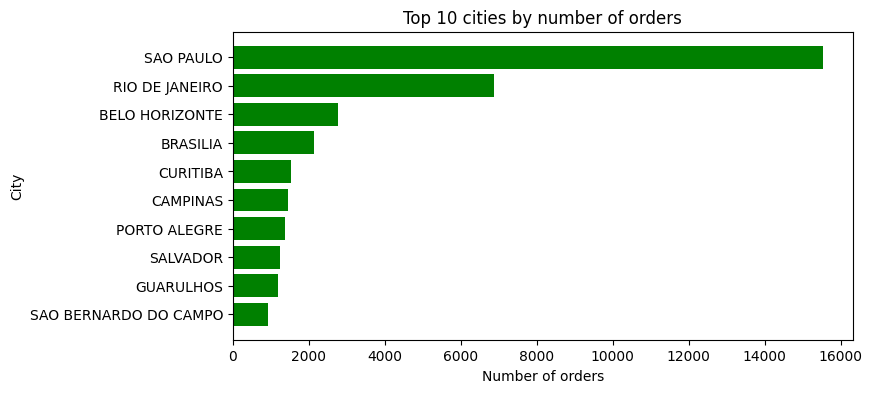

In [17]:
import matplotlib.pyplot as plt

top_cities = pd.read_sql_query(orders_per_city_reversed, db_connection)

plt.figure(figsize=(8, 4))
plt.barh(top_cities['city'], top_cities['city_order_count'],color='green')
plt.xlabel('Number of orders')
plt.ylabel('City')
plt.title('Top 10 cities by number of orders')
plt.show()

As we can see, a lot more orders are placed in Sao Paulo and Rio de Janerio than in other cities, as you'd expect since these are also the largest cities in Brazil. We'll take a closer look at the geographic distribution of orders later when we calculate customer lifetime value by zip code prefix.